<a href="https://colab.research.google.com/github/ArpitaChatterjee/Digit-Recognizer/blob/main/digit_recognizer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.simplefilter(action= 'ignore')
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

**Loading Dataset**

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/test.csv')
df_train = train.copy()
df_test = test.copy()

In [4]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [6]:
sample_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/sample_submission.csv')
print(train.info())
print('\n')
print(test.info())
print('\n')
print(sample_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB
None


In [7]:
#check null values in the train n test set
train.isnull().sum().sum()

0

In [8]:
test.isnull().sum().sum()

0

**Data Visualization**

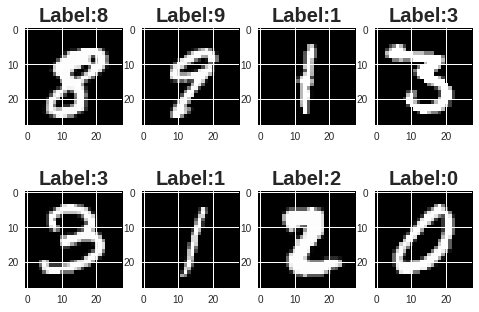

In [23]:
#Visualizing input images
df_tr =  df_train.iloc[:, 1:].values
yt = df_train.iloc[:,0].values
img1 = df_tr.reshape(df_tr.shape[0], 28, 28)
#plt.figure(figsize=(20,8))
for i in range(10, 18):
  plt.subplot(231 + (i))
  plt.imshow(img1[i], cmap='gray')
  plt.title('Label:' + str(yt[i]), fontweight = 'bold', size=20)
  

**Data Preprocessing**

In [24]:
#setting seeds for reproducibility
seed = 3141
np.random.seed(seed)

Splitting train and test data

In [25]:
# x= pixels & y= image labels
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]

#splitting dataframe using train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state= seed)


**Reshaping Images**
--> we have a 1D vector of 784px so gotta reshape it to (28x28x1) bfor passing it  to CNN. cuz keras wants extra dimension in the end for channels. in RGB images there would have been 3 channels but as MNIST is gray scale it uses only 1 .

In [26]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)
df_test = df_test.values.reshape(-1,28,28,1)

**Data Augmentation**

In terms of images , it means we can increases the no. of images our model sees.
Very Imp process. It can achived by rotating the image, flipping the image, zooming, changing light condition, cropping it , etc. (depends on the dataset; eg- here vertical flip is no useful since 6's 'll bcom 9 & vice-versa)

In [27]:
datagen = ImageDataGenerator(featurewise_center=False,#set input mean to 0 over the dataset
                             samplewise_center=False,#set each sample mean to 0
                             featurewise_std_normalization= False,#divide inputs by std of the dataset
                             samplewise_std_normalization= False,#divide each input by its std
                             zca_whitening= False,#apply ZCA whitening
                             rotation_range=10,#randomly rotate the imgs in range(deg 0->10)
                             zoom_range= 0.1,#randomly zoom img
                             width_shift_range= 0.1,#randomly shift img horizontaly ; fraction of total width
                             height_shift_range= 0.1,#randomly shift img vertically; factn of total height
                             horizontal_flip= False,#randomly flip img
                             vertical_flip= False)

**Normalization**

Pixel values are often stores as integers in the range 0 to 255, which is the range that int-8 can offer. Normalization:
(1) sets the value of inputs btw 0-1
(2)helps gradient descent coverange much faster
(3) bring features ot equal levels and weightage
(4) helps remove distortians in an img caused by light and shadows.

In [28]:
#convert values to float as result is float. if not done vals are set to 0
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255 

In [29]:
#fitting the Imgdatagenerator defined above
datagen.fit(x_train)

**One hot encoding labels**

since the labels are given bwtn 0-9. We need to one encode them. this is done so that we can have labels for all the classes, n we can easily carry out the error/cost dusing back propagation.

In [30]:
#num_class = 10 since no of diff labels=10
y_train= to_categorical(y_train, num_classes=10)
y_test= to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**Building CNN Model**

Steps:(1)sequential keras API 
(2)Add convolutional layers-building blocks of ConvNets and what do the heavy computaiton
(3)Add Pooling Layers-> setps along img- reduces params n decreases likelihood of overfitting
(4)Add batch normalization -> sccales down outliers n forces NN to not relaying too much on a perticular wt.
(5)Add Dropout layer-> regularization technique that randinky drops a percentage of neurons to avoid overfitting(20-50%)
(6)Add Flatten Layer-> flattens the input as 1D vector
(7)Add output layer-> units equals no of classes
(8)Add Dense layer-> fully connected layer which performs a linear opration on layer's input

In [31]:
model= Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=1,
                 padding='same', data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=1, padding='same',
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=1, padding='same',
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=1, padding='same',
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

**Compiling Model-> configure the learning process**





1.   Specify the Optimizer - The optimizer help us minimize the error function. Examples - RMSprop, Adam, AdaGrad, AdaDelta
2.   Specify Loss Function - For Binary Classification use "binary_crossentropy" and for Multi-class Classification use "categorical_crossentropy"
3. Specify the metrics to evaluate model performance






In [32]:
#optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)


In [33]:
#compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

**Learning Rate Decay** 
-> use LearningRateScheduler or ReduceLRonPlateau